# Train mini-ML model on 3d pose points

Train a random forest. 

Ideas:
* add age as feature to CSV -> this could be used as a feature in training(but introduces bias)

Learnings: 
* it helps to have 3D-components of bone vectors
* it helps to only keep the important bones
* confidence and validity do not help training a RF

Future work:
* Improve by median prediction of multiple artifacts
* make more robust: small model = few params
* XGboost
* try simple linear regression, select best features
* data augmentation

## Setup

In [28]:
# !pip install openmesh==1.1.6 threevis==0.1.0.post25

In [33]:
%reload_ext autoreload
%autoreload 2

from joblib import dump, load
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from constants import REPO_DIR, SKELETON_CGM
from train_util import get_artifact_id_from_path, get_features_from_fpath, plot_history, get_path_from_artifact_id, prepare_df, get_joints_from_fpath
from qa_config_pose3dpoints import RESULT_CONFIG, DATA_CONFIG
from config_train import CONFIG_TRAIN

sys.path.append(str(REPO_DIR / 'cgmml'))
from cgmml.common.evaluation.eval_utils import calculate_performance, calculate_performance_mae_artifact
from cgmml.common.evaluation.eval_utilities import calculate_and_save_results
from cgmml.common.evaluation.CV.evaluation import MINIMUM_CHILD_HEIGHT_IN_CM, MAXIMUM_CHILD_HEIGHT_IN_CM

In [3]:
DATA_DIR = REPO_DIR / 'data'
DATASET_DIR = REPO_DIR / 'data/datasets/pose3dpoints-dataset'; DATASET_DIR
NUM_ARTIFACTS_TO_SHOW = 3

INTERESTING_COLUMNS = ['height', 'weight', 'muac', 'scantype', 'abs_error']

# Eval
USE_FILTER_LOW_QUALITY_ARTIFACT = True

In [4]:
# import warnings
# warnings.filterwarnings('ignore')

In [5]:
df_ = pd.read_csv(DATASET_DIR / 'metadata.csv')
df_.rename(columns={"scan_type": "scantype"}, inplace=True)
df_ = df_.astype({'scantype': 'str'})
artifact_ids_all = list(df_['artifact_id'])

In [6]:
# Get artifacts obj file names from data dir
obj_files_paths_ = list(sorted(DATASET_DIR.glob('*.obj')))
obj_files_names_all = [get_artifact_id_from_path(path) for path in obj_files_paths_]

In [7]:
# Show that the CSV has more files than we have artifacts
x = set(artifact_ids_all)
y = set(obj_files_names_all)
z = x.intersection(y)
len(x), len(y), len(z)

(27919, 6898, 6898)

In [8]:
# Only keep the rows for which we have artifacts
df_all = df_[df_.artifact_id.isin(obj_files_names_all)]

# Sort dataframe by artifact_id
df_all = df_all.set_index('artifact_id')
df_all = df_all.sort_index()

# Make sure that file names are in the same order as the dataframe
assert np.all(obj_files_names_all == df_all.index)

df_all.shape, len(obj_files_names_all)

((6898, 11), 6898)

In [9]:
# Filter by scan type
df = df_all[df_all.scantype.isin(CONFIG_TRAIN.SCAN_TYPES_TO_USE)]
artifact_ids = list(df.index)

obj_files_names = [name for name in obj_files_names_all if name in artifact_ids]
obj_files_paths = [get_path_from_artifact_id(name, DATASET_DIR) for name in obj_files_names]

print(df.shape, len(obj_files_paths))
df.head()

(3035, 11) 3035


,scan_id,order,depthmap_path,rgb_path,height,weight,muac,scan_version,scantype,measurement_date,scan_date
artifact_id,,,,,,,,,,,
0816b862-8e1b-11eb-941c-dbaed44346b6,0816b860-8e1b-11eb-941c-ab8a1eff68ab,1.0,1616726354112/3428cc7a-002f-45ee-82f8-c4618ce8...,1616726346829/27fd9dca-694c-4593-b464-bb767f30...,66.6,6.75,12.8,v0.9,200,2021-03-25 11:22:08,2021-03-25 09:13:59
08183f00-8e1b-11eb-941c-cf2a8c1b927f,0816b860-8e1b-11eb-941c-ab8a1eff68ab,2.0,1616726354229/a1a926f5-a9eb-40d2-ab11-60e2fb7a...,1616726354149/39af2c90-d6d6-4bab-bcf8-33320a2c...,66.6,6.75,12.8,v0.9,200,2021-03-25 11:22:08,2021-03-25 09:13:59
08183f02-8e1b-11eb-941c-9b7184a99229,0816b860-8e1b-11eb-941c-ab8a1eff68ab,3.0,1616726354264/8a3d2cec-b395-4c44-a29e-323164e2...,1616726354194/ee2cf646-503a-4137-bc45-d9db5e4c...,66.6,6.75,12.8,v0.9,200,2021-03-25 11:22:08,2021-03-25 09:13:59
08183f04-8e1b-11eb-941c-a3304ecd1294,0816b860-8e1b-11eb-941c-ab8a1eff68ab,4.0,1616726360883/c1dd0daa-f682-4129-a11a-50735d20...,1616726361201/126b2218-34cb-4c80-97bc-c68ece9b...,66.6,6.75,12.8,v0.9,200,2021-03-25 11:22:08,2021-03-25 09:13:59
08183f06-8e1b-11eb-941c-6b69cb6bd4f4,0816b860-8e1b-11eb-941c-ab8a1eff68ab,5.0,1616726364111/587634dc-69d5-425b-9b1f-91c2ac1e...,1616726364587/5ccdb1e7-2c09-4c5e-80f4-aa5779dd...,66.6,6.75,12.8,v0.9,200,2021-03-25 11:22:08,2021-03-25 09:13:59


In [10]:
# Make sure that file names are in the same order as the dataframe
assert np.all(obj_files_names == df.index)

# df and obj_files_names are now prepared!

## Feature engineering

In [11]:
# Create columns by looking at first child's features
obj_file_path = obj_files_paths[0]
child_features = get_features_from_fpath(obj_file_path, config_train=CONFIG_TRAIN)

num_samples = len(obj_files_paths); print(num_samples)
num_features = len(child_features); print(num_features)

3035
46


In [12]:
# Check features of 1 child
# child_features

In [13]:
features_array = np.empty([num_samples, num_features])
features_array[:] = np.NaN

for artifact_index, obj_file_path in enumerate(obj_files_paths):
    child_features = get_features_from_fpath(obj_file_path, config_train=CONFIG_TRAIN)
    features_array[artifact_index] = np.array(list(child_features.values()))
assert np.all(~np.isnan(features_array))  # Check all features were calculated
features_array.shape

(3035, 46)

In [14]:
features_array.shape, df.shape

((3035, 46), (3035, 11))

In [15]:
# Split train, eval, test set
X = features_array  # df[["order", "scantype"]]
X_train_tmp, X_test, df_train_tmp, df_test = train_test_split(X, df, test_size=0.1, random_state=1)
X_train, X_val, df_train, df_val = train_test_split(X_train_tmp, df_train_tmp, test_size=0.1, random_state=1)

y_train = df_train.height
y_val = df_val.height
y_test = df_test.height

# all: 6898
# train: 5600
# validation: ca. 600
# testset: ca. 700

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(2457, 46) (2457,)
(274, 46) (274,)
(304, 46) (304,)


## Mean Baseline

In [16]:
# Mean baseline
y_true = y_test
height_mean = df.height.mean()
y_pred = [height_mean for _ in range(X_test.shape[0])]
mean_absolute_error(y_true, y_pred)

5.866451270267928

## Random Forest

In [17]:
regr = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=0)
regr.fit(X_train, y_train);

In [18]:
# Evaluate
y_true = df_val.height
y_pred = regr.predict(X_val)
mean_absolute_error(y_true, y_pred)

0.9362904979602213

In [19]:
# Save model
model_name = f'2021q4-points3d-rf-height-28k-{"and".join(CONFIG_TRAIN.SCAN_TYPES_TO_USE)}'
MODEL_PATH = DATA_DIR / f'models/pose3dpointsModel/{model_name}.joblib'
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
dump(regr, MODEL_PATH) 
regr = load(MODEL_PATH) 

In [20]:
# Check the predicted height is realistic

if USE_FILTER_LOW_QUALITY_ARTIFACT:
    y_pred = regr.predict(X_val)
    print('amount of all samples:', y_pred.shape[0])
    indexes = np.where((MINIMUM_CHILD_HEIGHT_IN_CM < y_pred) & (y_pred < MAXIMUM_CHILD_HEIGHT_IN_CM))[0]
    print('amount of sane samples:', indexes.shape[0])
    
    y_pred_ = y_pred[indexes]
    y_true_ = df_val.height.iloc[indexes]
    
    mae = mean_absolute_error(y_true_, y_pred_)
    print(f'mae (filtered): {mae:.2f}')

amount of all samples: 274
amount of sane samples: 274
mae (filtered): 0.94


In [21]:
# Evaluate per scan step
for scantype in DATA_CONFIG.CODES:
    indexes = np.where(df_val.scantype == scantype)[0]
    y_true_ = df_val.iloc[indexes].height
    if not X_val[indexes].any():
        continue
    y_pred_ = regr.predict(X_val[indexes])
    mae = mean_absolute_error(y_true_, y_pred_)
    print(f'{scantype}: {mae:.2f}')
    

200: 0.91
201: 0.95


In [22]:
df_val.loc[:, 'GT'] = df_val['height']
df_val.loc[:, 'predicted'] = y_pred
df_val.loc[:, 'error'] = df_val['GT'] - df_val['predicted']

csv_fpath = REPO_DIR / 'data/outputs/pose3dpointmodel/test_mae_artifact_level_pose3dpointmodel.csv'
calculate_and_save_results(df_val.copy(), 'pose3dpointmodel', csv_fpath,
                           DATA_CONFIG, RESULT_CONFIG, fct=calculate_performance_mae_artifact)

/Users/markus/Development/cgm/cgm-ml/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/markus/Development/cgm/cgm-ml/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [23]:
df_val_grouped = prepare_df(df_val.copy())
csv_out_fpath = REPO_DIR / 'data/outputs/pose3dpointmodel/pose3dpointmodel.csv'
calculate_and_save_results(df_val_grouped, 'pose3dpointmodel', csv_out_fpath, DATA_CONFIG, RESULT_CONFIG, fct=calculate_performance)

In [24]:
df_val.loc[:, 'abs_error'] = np.abs(df_val['error'])

(-3.0, 3.0)

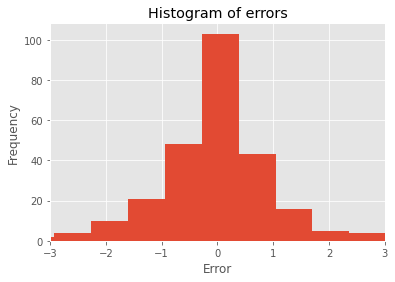

In [34]:
df_val['error'].hist(bins=20);
plt.ylabel('Frequency'); plt.xlabel('Error'); plt.title('Histogram of errors');
plt.xlim(-3, 3)

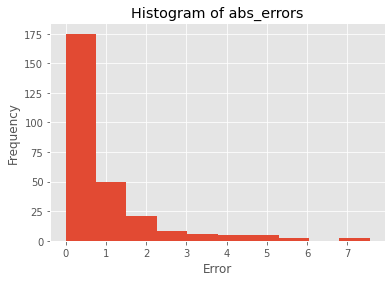

In [35]:
df_val['abs_error'].hist();
plt.ylabel('Frequency'); plt.xlabel('Error'); plt.title('Histogram of abs_errors');

In [27]:
# Sort by error
df_errors = df_val.sort_values('abs_error', ascending=False)

In [19]:
# Show some results
# for i in range(20):
#     pred = regr.predict([X_test[i]])
#     print(pred[0], 'actual:', y_test[i])

## Neural Network

In [31]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))

2021-10-20 16:46:50.105871: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-20 16:46:50.106390: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
# hyperparameters
model = models.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="linear")
])
LR = 0.003
BATCH_SIZE = 16

# Training code
optimizer = tf.keras.optimizers.RMSprop(learning_rate=LR)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

# checkpoint
MODEL_CKPT_FILENAME = "best_model.ckpt"
best_model_path = str(DATA_DIR / f'models/pose3dpointsModel/outputs/{MODEL_CKPT_FILENAME}')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=best_model_path,
    monitor="val_loss",
    save_best_only=True,
    verbose=-1
)

history = model.fit(
    dataset_train.repeat(5).batch(BATCH_SIZE),
    validation_data=dataset_validation.batch(BATCH_SIZE),
    epochs=60,
    verbose=2,
    callbacks=[checkpoint_callback]
)

model = tf.keras.models.load_model(best_model_path)
loss, mae = model.evaluate(dataset_train.batch(BATCH_SIZE))
val_loss, val_mae = model.evaluate(dataset_validation.batch(BATCH_SIZE))
print(f'mae: {mae}, val_mae: {val_mae}')

Epoch 1/60
768/768 - 2s - loss: 551.6611 - mae: 11.4759 - val_loss: 52.9084 - val_mae: 5.9796
INFO:tensorflow:Assets written to: /Users/markus/Development/cgm/cgm-ml/data/models/pose3dpointsModel/outputs/best_model.ckpt/assets
Epoch 2/60
768/768 - 2s - loss: 85.0255 - mae: 5.9356 - val_loss: 148.2546 - val_mae: 11.2659
Epoch 3/60
768/768 - 1s - loss: 58.9704 - mae: 5.3405 - val_loss: 29.7976 - val_mae: 4.6734
INFO:tensorflow:Assets written to: /Users/markus/Development/cgm/cgm-ml/data/models/pose3dpointsModel/outputs/best_model.ckpt/assets
Epoch 4/60
768/768 - 1s - loss: 94.7973 - mae: 4.6802 - val_loss: 18.5614 - val_mae: 3.1884
INFO:tensorflow:Assets written to: /Users/markus/Development/cgm/cgm-ml/data/models/pose3dpointsModel/outputs/best_model.ckpt/assets
Epoch 5/60
768/768 - 1s - loss: 40.0703 - mae: 4.3774 - val_loss: 10.0594 - val_mae: 2.2834
INFO:tensorflow:Assets written to: /Users/markus/Development/cgm/cgm-ml/data/models/pose3dpointsModel/outputs/best_model.ckpt/assets
Epoc

In [1]:
history

history


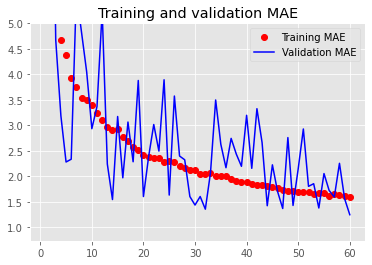

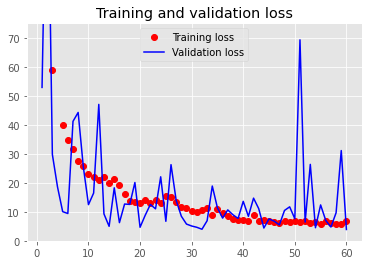

In [35]:
plot_history(history)

## Visualize good and bad predictions 

Visualization in 3D using [threevis](https://gitlab.vci.rwth-aachen.de:9000/threevis/threevis)

In [36]:
import threevis as tv
import openmesh as om

def draw_3d(mesh):
    ctx = tv.Context(width=320, height=240)  # width=640, height=480)  # Create Context
    vertices = mesh.points()  # Get vertices and faces from the mesh
    ctx.draw_edges(vertices, SKELETON_CGM)
    ctx.draw_vertices(vertices, point_size=4, colors='red')  # Draw a point for each vertex
    ctx.display()

In [37]:
# Show a sample visualization

m = om.read_trimesh(str(obj_files_paths[13]))
draw_3d(m)

/Users/markus/Development/cgm/cgm-ml/.venv/lib/python3.7/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

In [38]:
def draw_artifact(artifact_id):
    obj_file_path = get_path_from_artifact_id(artifact_id, DATASET_DIR)
    m = om.read_trimesh(str(obj_file_path))
    draw_3d(m)

    # print confidence values
    joints = get_joints_from_fpath(obj_file_path)
    confidences = [joint.confidence for joint in joints]
    print('mean confidence:', np.mean(confidences), 'confidences:', confidences)

In [39]:
# Worst predictions
for artifact_id, row in df_errors[INTERESTING_COLUMNS].head(NUM_ARTIFACTS_TO_SHOW).iterrows():
    print(row)
    draw_artifact(artifact_id)

height          66.2
weight          6.95
muac            13.6
scantype         201
abs_error    7.56321
Name: b3a1f2c9-8d4f-11eb-a9dd-fbde9b776d47, dtype: object


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

mean confidence: 0.9389567725798663 confidences: [0.9981110095977783, 1.002624273300171, 0.963022768497467, 0.9535688757896423, 0.9803876876831055, 0.9472681879997253, 0.9623740315437317, 0.9433605074882507, 0.9664832949638367, 0.9436720609664917, 0.9505259394645691, 0.7844178676605225, 0.845750093460083, 0.8530886769294739, 0.9418039321899414, 0.9706621766090393, 0.9551437497138977]
height        63.5
weight        6.45
muac          13.5
scantype       201
abs_error    7.551
Name: 82ade7a7-8d4f-11eb-a9dd-ab13dc563fa0, dtype: object


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

mean confidence: 0.9202034999342525 confidences: [0.993766188621521, 1.0309422016143799, 0.9899661540985107, 0.9068850874900818, 0.9950156211853027, 0.8957086205482483, 0.8905441164970398, 0.8718391060829163, 0.9610781669616699, 0.8512191772460938, 0.9691656231880188, 0.9629018306732178, 0.8757877349853516, 0.9675906300544739, 0.968380331993103, 0.6602904200553894, 0.8523784875869751]
height          75.4
weight           8.1
muac            12.7
scantype         200
abs_error    5.67235
Name: e6c82b82-9202-11eb-b3e6-8f3a4a7d1eee, dtype: object


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

mean confidence: 0.89603770831052 confidences: [0.9731804132461548, 1.0035098791122437, 0.9711766839027405, 0.7214691638946533, 0.9366785883903503, 0.9272057414054871, 0.9160175323486328, 0.948057234287262, 0.9027912616729736, 0.9463530778884888, 0.9184790849685669, 0.673651933670044, 0.7311875820159912, 0.9600550532341003, 0.9654477834701538, 0.8324926495552063, 0.9048873782157898]


In [40]:
# Best predictions
for artifact_id, row in df_errors[INTERESTING_COLUMNS].tail(NUM_ARTIFACTS_TO_SHOW).iterrows():
    print(row)
    draw_artifact(artifact_id)


height              87.1
weight             11.75
muac                14.2
scantype             201
abs_error    1.56319e-13
Name: 6d5da221-8b8b-11eb-b152-d38290958b89, dtype: object


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

mean confidence: 0.9225923629368052 confidences: [0.9805140495300293, 0.9723192453384399, 0.9758297801017761, 0.9272516965866089, 0.9298948645591736, 0.9288510084152222, 0.9358725547790527, 1.0427991151809692, 0.9674875736236572, 0.9005864262580872, 0.9650750756263733, 0.81565260887146, 0.9005478620529175, 0.8727996349334717, 0.8543975949287415, 0.8702600598335266, 0.8439310193061829]
height              87.1
weight             11.75
muac                14.2
scantype             201
abs_error    1.56319e-13
Name: 5d9c8186-8b04-11eb-8680-a3c79a4d407e, dtype: object


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

mean confidence: 0.9381029956481036 confidences: [1.016287922859192, 1.0042027235031128, 0.9988529086112976, 0.913713276386261, 0.9623432159423828, 0.9369111061096191, 0.9489009976387024, 0.9809321761131287, 0.9485164880752563, 0.8583805561065674, 0.9548801183700562, 0.8866220712661743, 0.8608142733573914, 0.8532166481018066, 0.911930501461029, 1.0351910591125488, 0.8760548830032349]
height              87.1
weight             11.75
muac                14.2
scantype             201
abs_error    1.56319e-13
Name: 5d97eda5-8b04-11eb-8680-9bb11d0b64fc, dtype: object


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

mean confidence: 0.9180052385610693 confidences: [0.9798208475112915, 1.006314754486084, 0.9991999864578247, 0.921204149723053, 0.9156040549278259, 0.9377880692481995, 0.9433749914169312, 0.9935334324836731, 0.9436258673667908, 0.945797324180603, 0.956637442111969, 0.848861038684845, 0.8111210465431213, 0.8536525368690491, 0.8467532992362976, 0.8113805651664734, 0.8914196491241455]
